<a href="https://colab.research.google.com/github/sprhdr/Modeling-Marketing-Mix-with-PyMC3/blob/main/Copy_of_MMM_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import warnings; 
warnings.simplefilter('ignore')

In [ ]:
!pip install pymc3
!pip install scikit-misc

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import sys
import os
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy import optimize
from scipy.stats.mstats import mquantiles
from plotnine import *
from prophet import Prophet
plt.rcParams['font.size'] = 18

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
#suppress exponential notation, define an appropriate float formatter
#specify stdout line width and let pretty print do the work
np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)

In [ ]:
START_ANALYSIS_INDEX = 1
END_ANALYSIS_INDEX = 104

In [ ]:
# loading dataset to a pandas dataframe
url = 'https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv'
data = pd.read_csv(url)
data.columns = [c.lower() if c in ["start_of_week"] else c for c in data.columns]
data

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
0,30-08-20,157906.75000,2625.48000,262.71000,12954.12000,3609.63000,12955.29000,12659.12000,19379.79000
1,06-09-20,186425.68000,2634.01000,108.66000,8760.28000,4560.60000,12747.70000,12338.18000,22473.45000
2,13-09-20,161607.39000,2087.08000,110.32000,7155.42000,4362.96000,15015.41000,10811.15000,22596.05000
3,20-09-20,180089.13000,1690.70000,52.79000,15185.22000,3883.41000,15521.41000,12890.22000,24728.73000
4,27-09-20,217793.98000,1547.30000,80.56000,18524.05000,4043.09000,15793.74000,12642.55000,26515.48000
...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50000,0.00000,1118.78000,22305.10000,4566.01000,2987.70000,0.00000,19916.88000
100,31-07-22,90786.21000,0.00000,122.16000,15812.65000,4795.51000,3293.40000,0.00000,22687.98000
101,07-08-22,105929.40000,0.00000,754.09000,12166.85000,4961.12000,4057.03000,0.00000,30142.64000
102,14-08-22,90506.31000,0.00000,1043.22000,10856.58000,4431.13000,3086.81000,0.00000,28622.78000


In [ ]:
prophet_data = data.rename(columns = {'revenue': 'y', 'start_of_week': 'ds'})

In [ ]:
prophet = Prophet(yearly_seasonality=True)

In [ ]:
prophet.fit(prophet_data[["ds", "y"]])
prophet_predict = prophet.predict(prophet_data[["ds", "y"]])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprogka3qr/5rcw4r5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprogka3qr/30ppsm6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93239', 'data', 'file=/tmp/tmprogka3qr/5rcw4r5m.json', 'init=/tmp/tmprogka3qr/30ppsm6y.json', 'output', 'file=/tmp/tmprogka3qr/prophet_modelca_hsyz1/prophet_model-20230108174523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


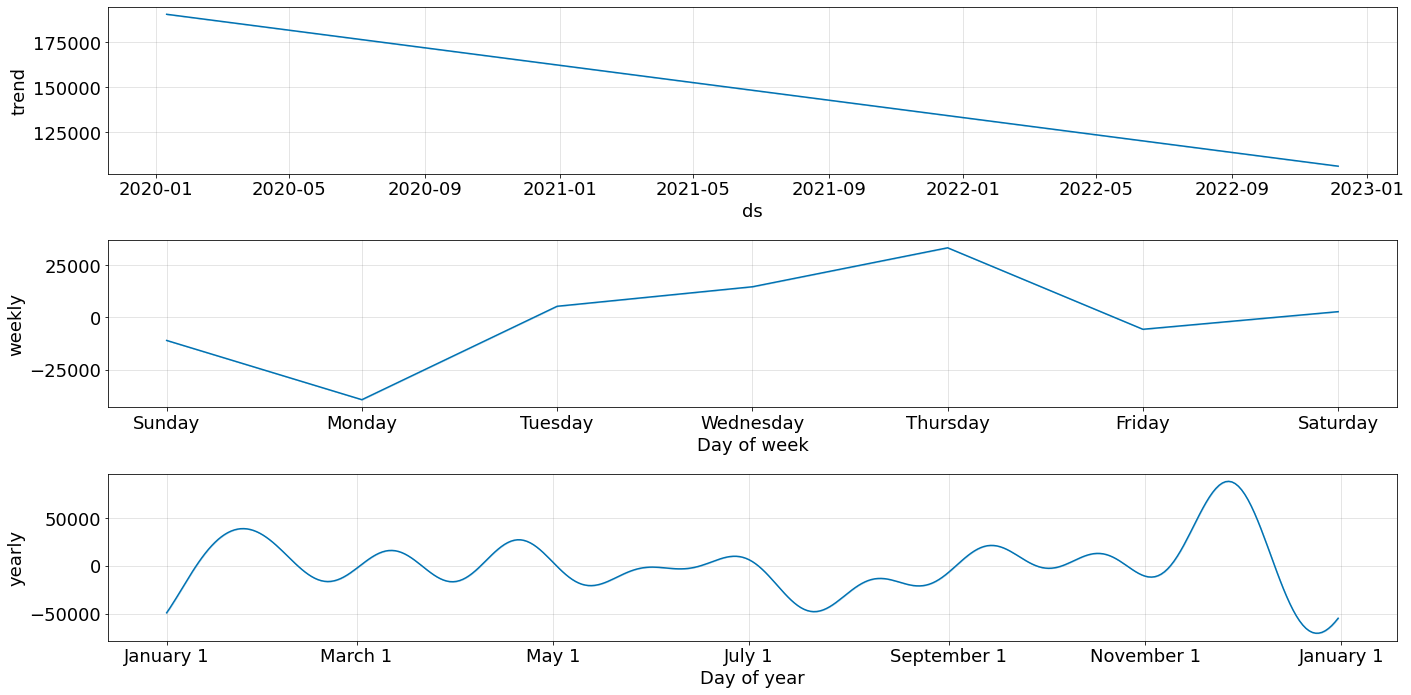

In [ ]:
plot = prophet.plot_components(prophet_predict, figsize = (20, 10))

In [ ]:
prophet_columns = [col for col in prophet_predict.columns if (col.endswith("upper") == False) & (col.endswith("lower") == False)]

final_data = data.copy()
final_data["trend"] = prophet_predict["trend"]
final_data["season"] = prophet_predict["yearly"]

In [ ]:
spend_to_exposure_menten_func = lambda spend, V_max, K_m: V_max * spend / (K_m + spend)
exposure_to_spend_menten_func = lambda exposure, V_max, K_m: exposure * K_m / (V_max - exposure)

In [ ]:
media_exposures = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]
media_spends = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

media_spend_exposure_df = pd.DataFrame()
for (media_exposure, media_spend) in zip(media_exposures, media_spends):
    V_max = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX].max()
    K_m   = V_max / 2
    spend = final_data[media_spend].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    exposure = final_data[media_exposure].values[START_ANALYSIS_INDEX : END_ANALYSIS_INDEX]
    best_values, _ = optimize.curve_fit(f = spend_to_exposure_menten_func, xdata = spend, ydata = exposure, p0 = [V_max, K_m])
    media_spend_exposure_df = pd.concat([media_spend_exposure_df, pd.DataFrame({'spend': [media_spend], 'exposure': [media_exposure], 'V_max': [best_values[0]], 'K_m': [best_values[1]]})]).reset_index(drop = True)
    
media_spend_exposure_df

,spend,exposure,V_max,K_m
0,spend_channel_1,spend_channel_1,1452968920478.00781,1452968916051.28906
1,spend_channel_2,spend_channel_2,189325236685.55951,189325235773.04974
2,spend_channel_3,spend_channel_3,6007305348078.57324,6007305320239.07617
3,spend_channel_4,spend_channel_4,2291307455432.73242,2291307444766.67920
4,spend_channel_5,spend_channel_5,2827599484876.03516,2827599466934.41846
5,spend_channel_6,spend_channel_6,4822886544287.65430,4822886525078.35254
6,spend_channel_7,spend_channel_7,8049479815275.12695,8049479776088.66602


In [ ]:
data.iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]

,start_of_week,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
1,06-09-20,186425.68000,2634.01000,108.66000,8760.28000,4560.60000,12747.70000,12338.18000,22473.45000
2,13-09-20,161607.39000,2087.08000,110.32000,7155.42000,4362.96000,15015.41000,10811.15000,22596.05000
3,20-09-20,180089.13000,1690.70000,52.79000,15185.22000,3883.41000,15521.41000,12890.22000,24728.73000
4,27-09-20,217793.98000,1547.30000,80.56000,18524.05000,4043.09000,15793.74000,12642.55000,26515.48000
5,04-10-20,195581.04000,3655.19000,525.06000,18024.45000,9739.47000,20804.05000,25445.63000,30394.41000
...,...,...,...,...,...,...,...,...,...
99,24-07-22,72021.50000,0.00000,1118.78000,22305.10000,4566.01000,2987.70000,0.00000,19916.88000
100,31-07-22,90786.21000,0.00000,122.16000,15812.65000,4795.51000,3293.40000,0.00000,22687.98000
101,07-08-22,105929.40000,0.00000,754.09000,12166.85000,4961.12000,4057.03000,0.00000,30142.64000
102,14-08-22,90506.31000,0.00000,1043.22000,10856.58000,4431.13000,3086.81000,0.00000,28622.78000


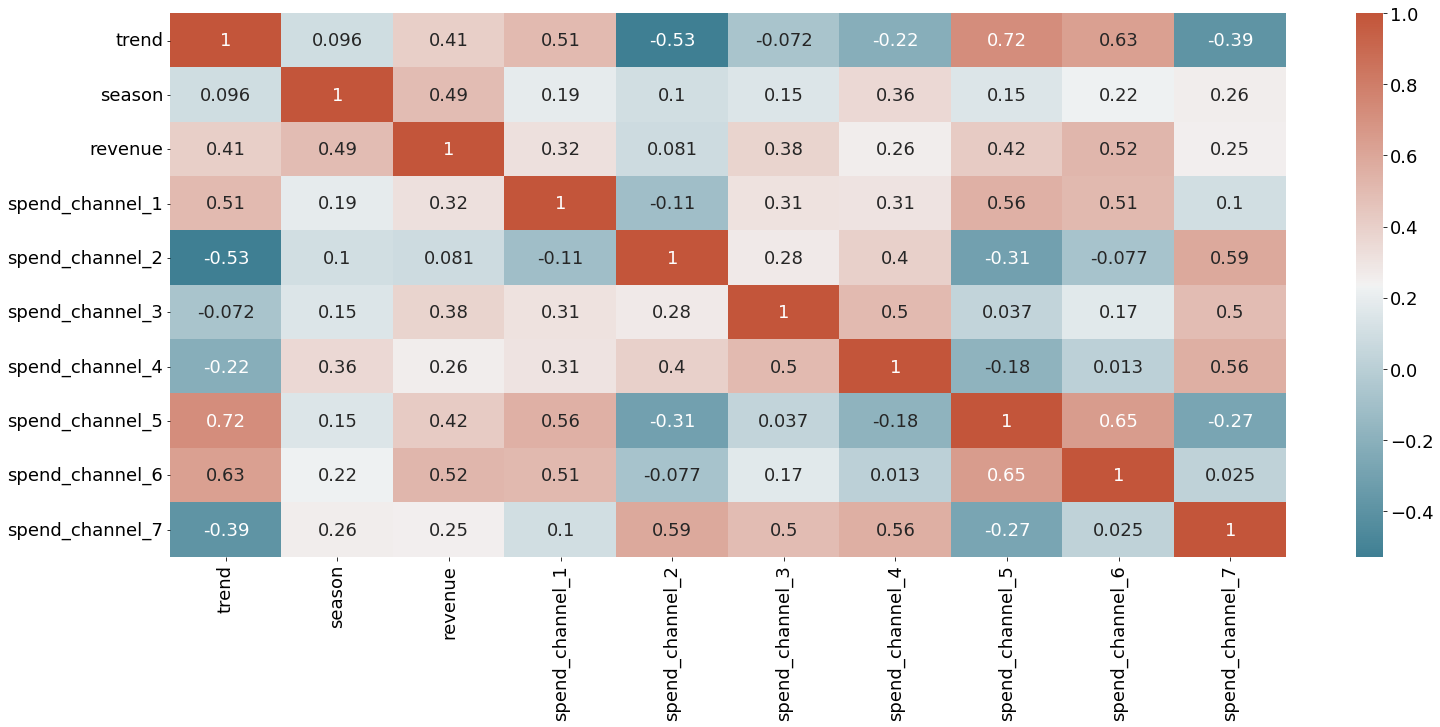

In [ ]:
data = final_data
corr = data[["trend", "season", "revenue", "spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]].corr()

fig, ax = plt.subplots(figsize=(25,10))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True, cmap = sns.diverging_palette(220, 20, as_cmap=True))

In [ ]:
def adstock_geometric(x: float, theta: float):
    x_decayed = np.zeros_like(x)
    x_decayed[0] = x[0]
                               
    for xi in range(1, len(x_decayed)):
        x_decayed[xi] = x[xi] + theta * x_decayed[xi - 1]

    return x_decayed

def adstock_geometric_theano_pymc3(x, theta):
    x = tt.as_tensor_variable(x)
    #x = tt.vector("x")
    #theta = tt.scalar("theta")

    def adstock_geometric_recurrence_theano(index, input_x, decay_x, theta):
        return tt.set_subtensor(decay_x[index], tt.sum(input_x + theta * decay_x[index - 1]))

    len_observed = x.shape[0]

    x_decayed = tt.zeros_like(x)
    x_decayed = tt.set_subtensor(x_decayed[0], x[0])

    output, _ = theano.scan(
        fn = adstock_geometric_recurrence_theano, 
        sequences = [tt.arange(1, len_observed), x[1:len_observed]], 
        outputs_info = x_decayed,
        non_sequences = theta, 
        n_steps = len_observed - 1
    )
    
    return output[-1]


def saturation_hill_pymc3(x, alpha, gamma): 
    
    x_s_hill = x ** alpha / (x ** alpha + gamma ** alpha)
    
    return x_s_hill


#from https://github.com/ikatsov/tensor-house/blob/master/promotions/mediamix-bayesian.ipynb

#plots priors using the random variables
def plot_priors(variables, prior_dictionary = None):
    if isinstance(variables[0], pm.model.TransformedRV) == False and prior_dictionary is None:
        raise Exception("prior dictionary should be provided. It can be generated by sample_prior_predictive")
    cols = 2
    rows = int(math.ceil(len(variables)/cols))
    fig, ax = plt.subplots(rows, cols, figsize=(15, 3*rows))
    ax = np.reshape(ax, (-1, cols))
    for i in range(rows):
         for j in range(cols):
            vi = i*cols + j
            if vi < len(variables):
                var = variables[vi]
                if isinstance(var, pm.model.TransformedRV):
                    sns.histplot(var.random(size=10000).flatten(), kde=True, ax=ax[i, j])
                    #p.set_axis_labels(var.name)
                    ax[i, j].set_title(var.name)
                else:
                    prior = prior_dictionary[var]
                    sns.histplot(prior, kde=True, ax = ax[i, j])
                    ax[i, j].set_title(var)
    plt.tight_layout()
    
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

def nrmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2)) / (np.max(y_true) - np.min(y_true))


def plot_residuals(actual_vs_predicted: pd.DataFrame, figure_size = (15, 10)):
    """Residual plot

    Args:
        actual_vs_predicted (pd.DataFrame): Data Frame with three columns: date, actual, predicted
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).
    """
    
    plt = ggplot(actual_vs_predicted, aes("predicted", y = "actual - predicted"))\
    + geom_point(size = 2, show_legend = True)\
    + geom_hline(yintercept = 0, linetype = "dashed")\
    + geom_smooth(se=True, method = "loess", color = "blue")\
    + ggtitle("Actuals vs. predicted response") + xlab("predicted") + ylab("residual")\
    + theme(figure_size = figure_size,
                        legend_direction='horizontal', 
                        legend_position= "bottom",
                        legend_box_spacing=0.5,
                        legend_key_size=20, 
                        legend_entry_spacing_y=10, 
                        axis_text_y=element_text(weight="bold", size = 10)
        ) 
    
    return plt   


def plot_spend_vs_effect_share(decomp_spend: pd.DataFrame, figure_size = (15, 10)):
    """Spend vs Effect Share plot

    Args:
        decomp_spend (pd.DataFrame): Data with media decompositions. The following columns should be present: media, spend_share, effect_share per media variable
        figure_size (tuple, optional): Figure size. Defaults to (15, 10).

    Example:
        decomp_spend:
        media         spend_share effect_share
        tv_S           0.31        0.44
        ooh_S          0.23        0.34
    
    Returns:
        [plotnine]: plotnine plot
    """
    
    plot_spend_effect_share = decomp_spend.melt(id_vars = ["media"], value_vars = ["spend_share", "effect_share"])

    plt = ggplot(plot_spend_effect_share, aes("media", "value", fill = "variable")) \
    + geom_bar(stat = "identity", position = "dodge") \
    + geom_text(aes(label = "value * 100", group = "variable"), color = "darkblue", position=position_dodge(width = 0.5), format_string = "{:.2f}%") \
    + coord_flip() \
    + ggtitle("Share of Spend VS Share of Effect") + ylab("") + xlab("") \
    + theme(figure_size = figure_size, 
                    legend_direction='vertical', 
                    legend_title=element_blank(),
                    legend_key_size=20, 
                    legend_entry_spacing_y=5) 
    return plt

In [ ]:
transform_variables = ["trend",	"season", "spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

delay_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

media_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

control_variables = ["trend", "season"]

target = "revenue"

data_transformed = data.copy()


numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

dependent_transformation = None
original = data[target].values
data_transformed[target] = original / 100_000
    
response_mean = []
with pm.Model() as model_2:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 3)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", sd = 3)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    intercept = pm.Normal("intercept", np.mean(data_transformed[target].values), sd = 3)
    #intercept = pm.HalfNormal("intercept", 0, sd = 3)
        
    sigma = pm.HalfNormal("sigma", 4)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
    

Delay Channels: Adding spend_channel_1
Delay Channels: Adding spend_channel_2
Delay Channels: Adding spend_channel_3
Delay Channels: Adding spend_channel_4
Delay Channels: Adding spend_channel_5
Delay Channels: Adding spend_channel_6
Delay Channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season


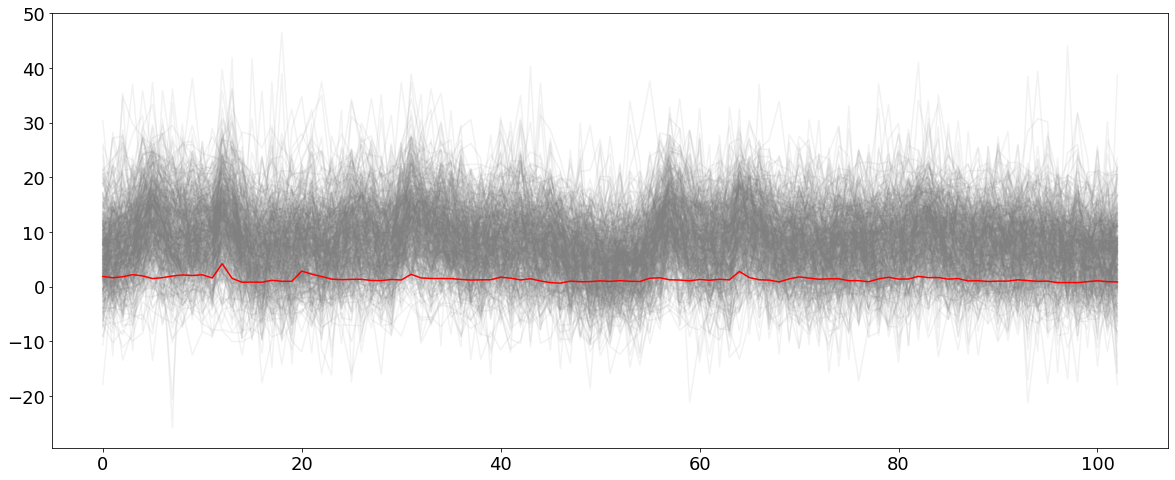

In [ ]:
with model_2:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

In [ ]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]
len(prior_names)

33

adstock priors: 7
alpha priors: 7
gamma priors: 7
media coef priors: 7
control coef priors: 3
sigma prior: 1


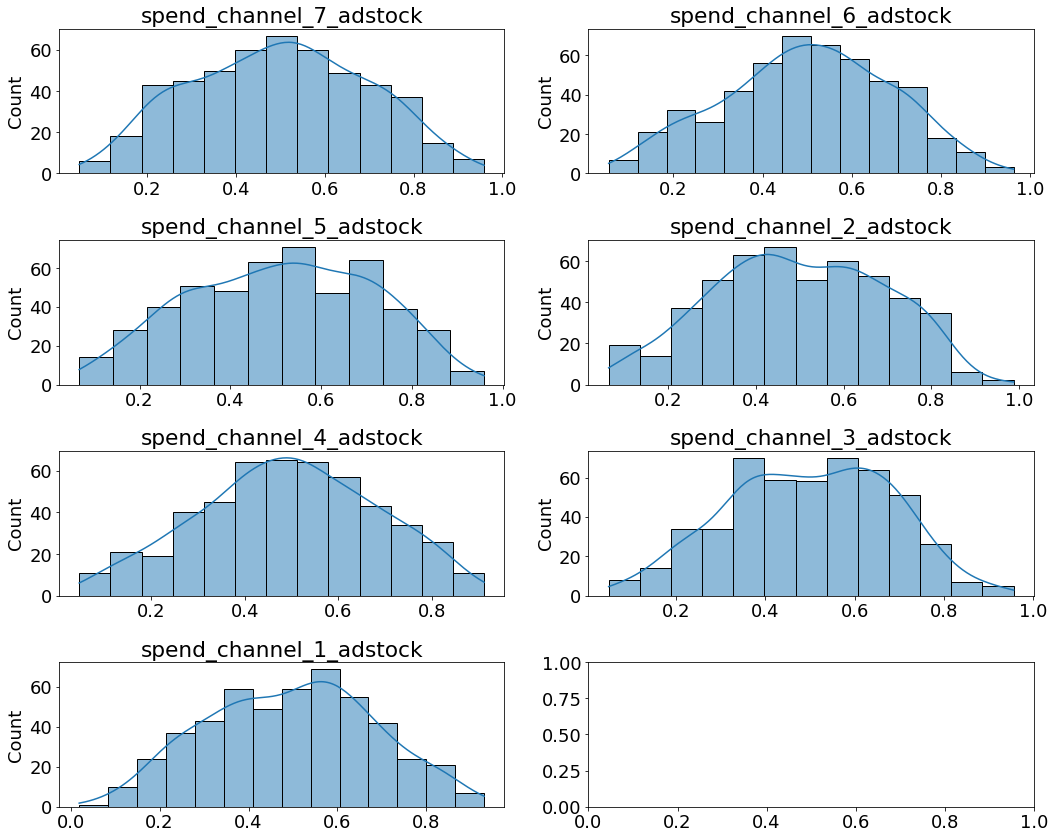

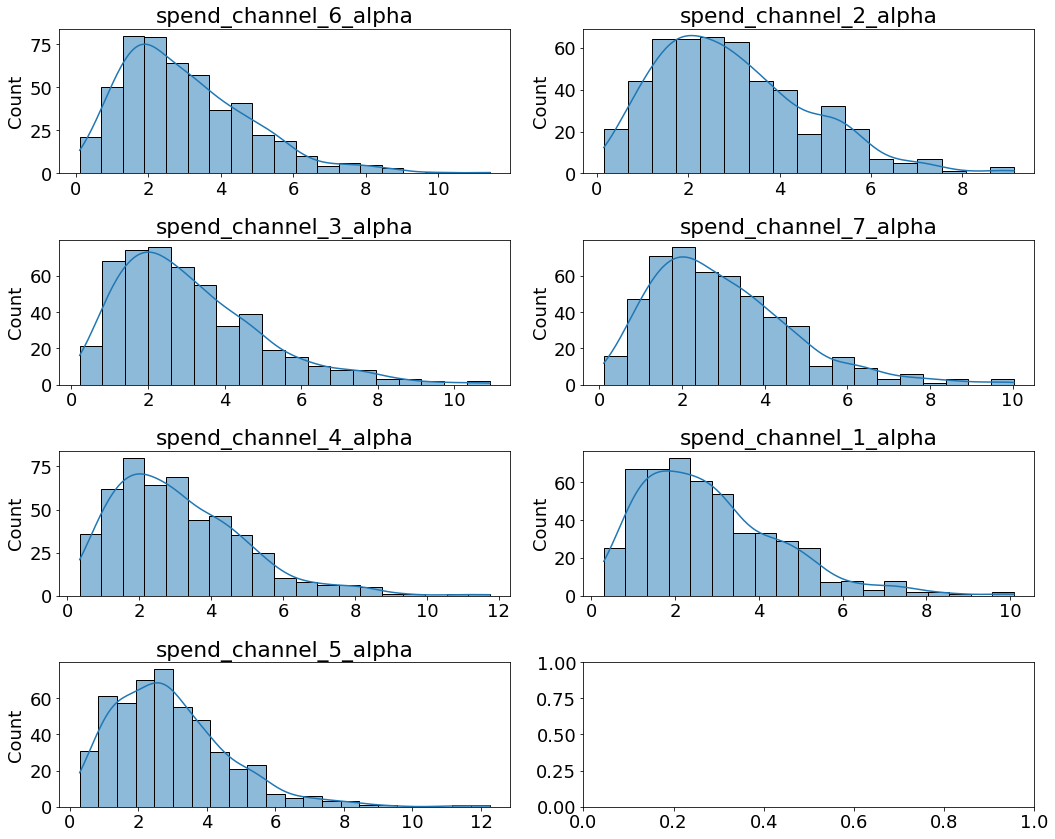

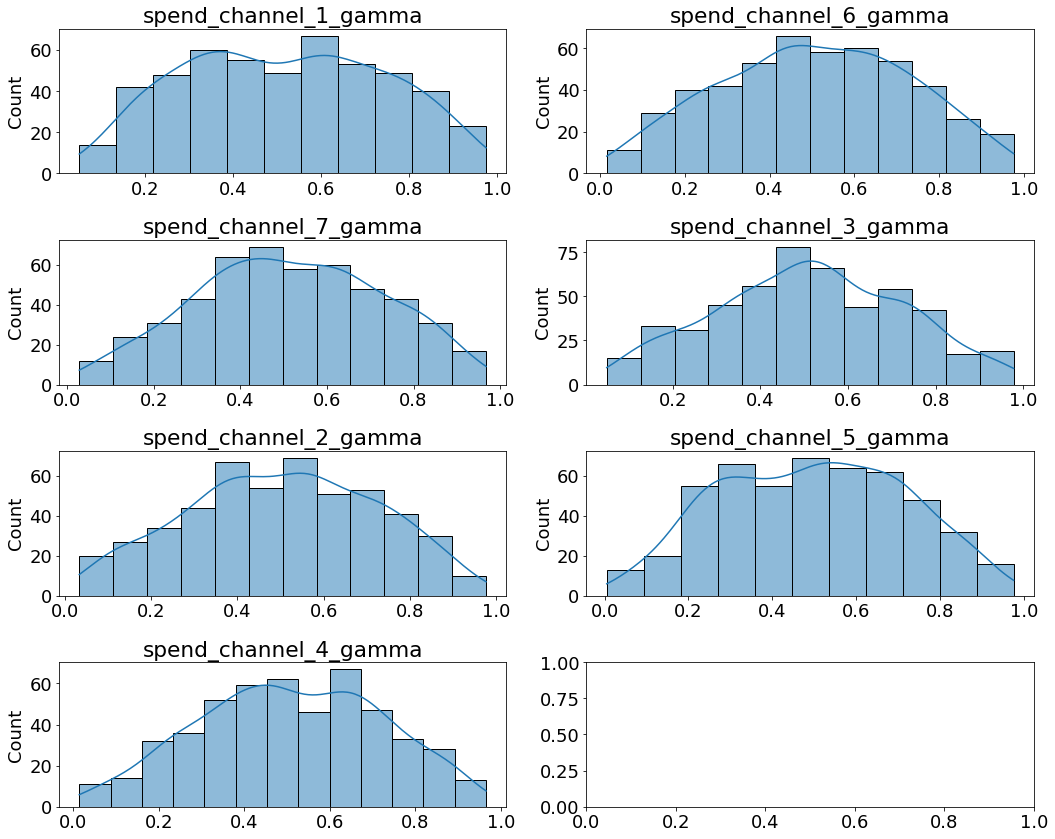

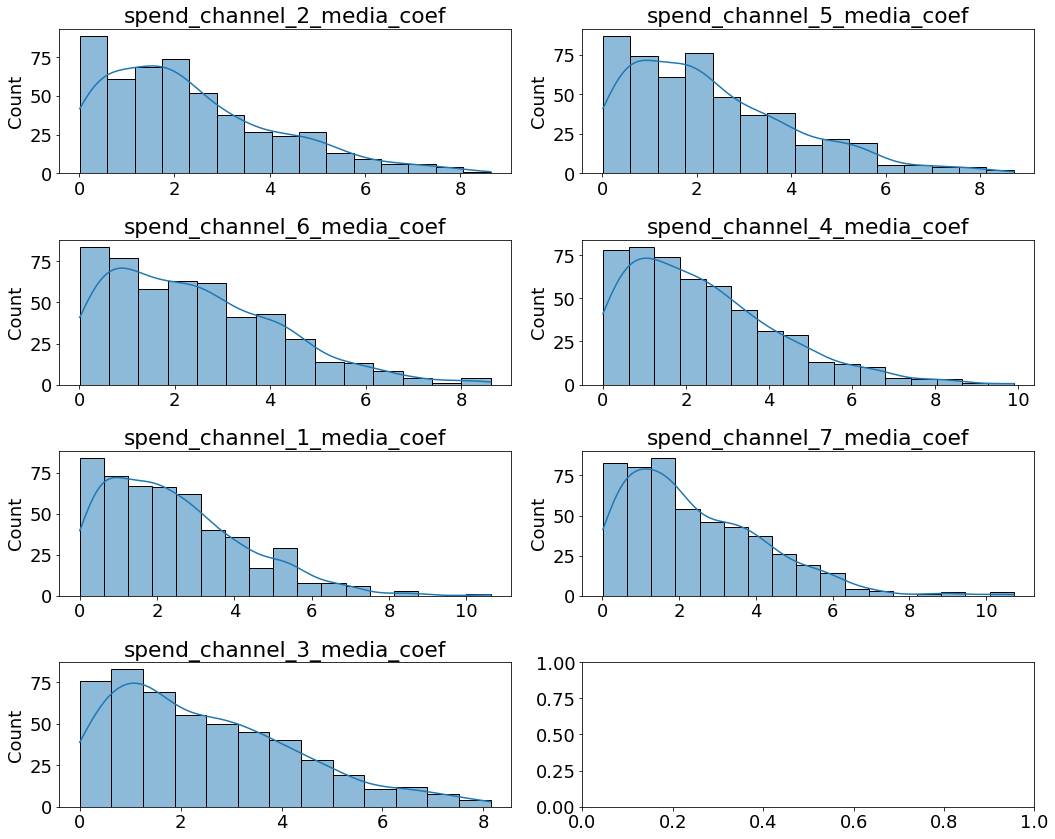

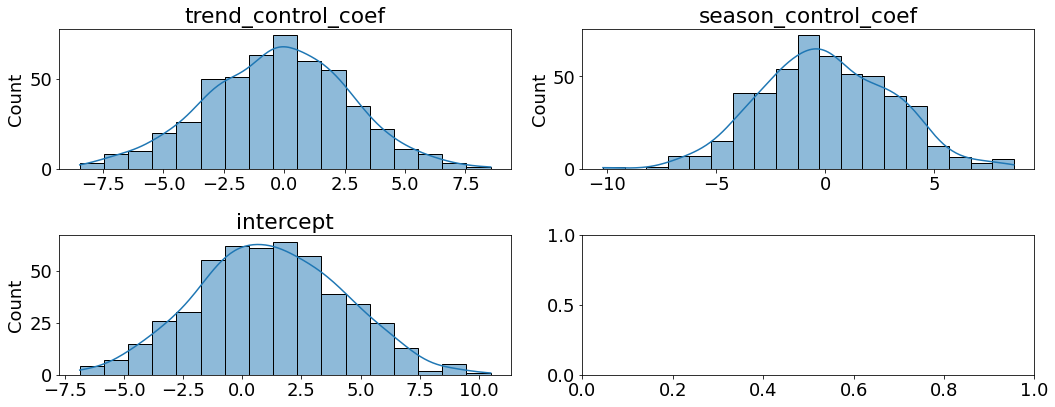

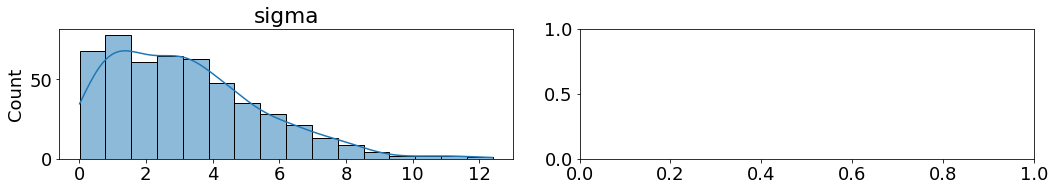

In [ ]:
adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

In [ ]:
with model_2:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

ERROR:pymc3:There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
trace_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend_control_coef,0.82300,0.36800,0.15100,1.50700,0.01000,0.00700,1306.00000,1421.00000,1.00000
season_control_coef,0.92200,0.21500,0.52500,1.34700,0.00500,0.00400,1944.00000,1277.00000,1.00000
intercept,-0.12000,0.31400,-0.75100,0.41300,0.01300,0.01000,632.00000,755.00000,1.01000
spend_channel_1_adstock,0.52000,0.20800,0.16100,0.90500,0.00500,0.00400,1756.00000,1021.00000,1.00000
spend_channel_1_gamma,0.50000,0.24300,0.08000,0.90900,0.00500,0.00400,1969.00000,1151.00000,1.00000
spend_channel_1_alpha,2.80200,1.82200,0.12200,6.00800,0.04200,0.03000,1357.00000,777.00000,1.00000
spend_channel_1_media_coef,0.11100,0.12400,0.00000,0.30400,0.00400,0.00300,1142.00000,1026.00000,1.00000
spend_channel_2_adstock,0.39000,0.16200,0.09500,0.68000,0.00400,0.00300,1540.00000,1248.00000,1.00000
spend_channel_2_gamma,0.61600,0.17900,0.32300,0.94200,0.00500,0.00300,1589.00000,1061.00000,1.00000
spend_channel_2_alpha,3.47600,1.81900,0.37400,6.60900,0.04300,0.03000,1228.00000,832.00000,1.00000


In [ ]:
with model_2:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )

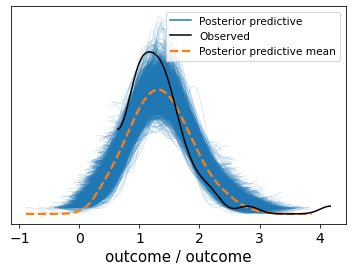

In [ ]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_2), var_names = ["outcome"])

In [ ]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    #mean_variable = ppc_all[variable].mean()
    mean_variable = trace.posterior[variable].mean(axis = 0).mean().values
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = ppc_all["outcome"].mean(axis = 0) * 100_000

print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 33642.47184178915
MAPE: 0.1789660366087506
NRMSE: 0.09477305518806223


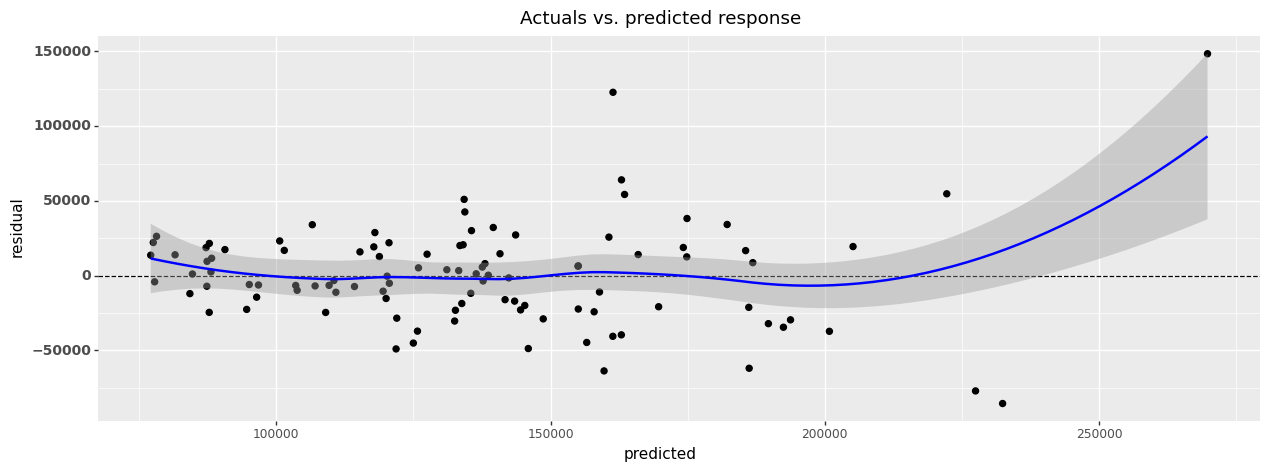

In [ ]:
plot = plot_residuals(pd.DataFrame({"actual": y_true, "predicted": y_pred}), figure_size = (15, 5))
print(plot)

In [ ]:
adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))

In [ ]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef

Intercept: -0.11972732984465588
spend_channel_1
	adstock 0.5204127957162374 transformation
	saturation alpha 2.801883423234798, gamma 0.50042885302333 transformation
	coefficient: 0.11051955006856705
spend_channel_2
	adstock 0.3896199216909904 transformation
	saturation alpha 3.475587271079995, gamma 0.616263904457672 transformation
	coefficient: 0.4257406092362574
spend_channel_3
	adstock 0.3276887391435605 transformation
	saturation alpha 2.7744379482415606, gamma 0.6228312037333946 transformation
	coefficient: 0.526138971148878
spend_channel_4
	adstock 0.45442127163912593 transformation
	saturation alpha 2.7669133619626938, gamma 0.5359175033744523 transformation
	coefficient: 0.16813392213006675
spend_channel_5
	adstock 0.4104663899199355 transformation
	saturation alpha 3.139431573826814, gamma 0.5659295633146166 transformation
	coefficient: 0.2652975016348762
spend_channel_6
	adstock 0.4561979581382674 transformation
	saturation alpha 3.1009969376747537, gamma 0.4939195601635585 

RMSE: 35737.11804818231
MAPE: 0.18813167753324936
NRMSE: 0.09477305518806223


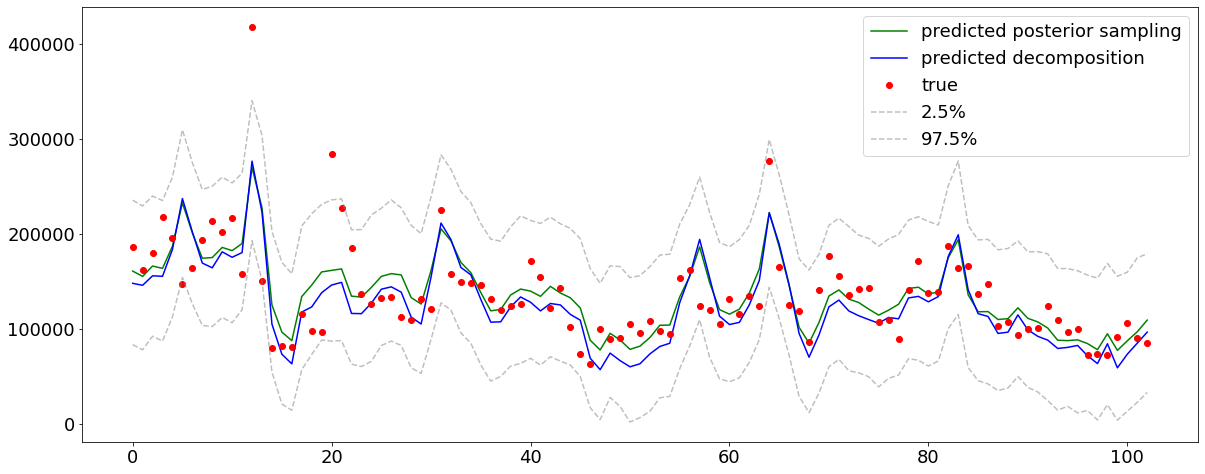

In [ ]:
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = data_transformed_decomposed["prediction"].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX] * 100_000


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")
qs = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(100_000 * (ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot((ppc_all["outcome"].mean(axis = 0) * 100_000), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [ ]:
media_spend_exposure_df

,spend,exposure,V_max,K_m
0,spend_channel_1,spend_channel_1,1452968920478.00781,1452968916051.28906
1,spend_channel_2,spend_channel_2,189325236685.55951,189325235773.04974
2,spend_channel_3,spend_channel_3,6007305348078.57324,6007305320239.07617
3,spend_channel_4,spend_channel_4,2291307455432.73242,2291307444766.67920
4,spend_channel_5,spend_channel_5,2827599484876.03516,2827599466934.41846
5,spend_channel_6,spend_channel_6,4822886544287.65430,4822886525078.35254
6,spend_channel_7,spend_channel_7,8049479815275.12695,8049479776088.66602


In [ ]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,spend_channel_1,126917.41986,0.01776
1,spend_channel_2,35475.94995,0.00496
2,spend_channel_3,2015792.38852,0.28200
3,spend_channel_4,715564.58927,0.10010
4,spend_channel_5,878908.29883,0.12296
5,spend_channel_6,513965.57943,0.07190
6,spend_channel_7,2861562.41783,0.40032


In [ ]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,spend_channel_1,126917.41986,0.01776,2.68960,0.04295
1,spend_channel_2,35475.94995,0.00496,8.80763,0.14065
2,spend_channel_3,2015792.38852,0.28200,16.52507,0.26390
3,spend_channel_4,715564.58927,0.10010,3.60984,0.05765
4,spend_channel_5,878908.29883,0.12296,8.43701,0.13474
5,spend_channel_6,513965.57943,0.07190,8.26278,0.13195
6,spend_channel_7,2861562.41783,0.40032,14.28679,0.22816


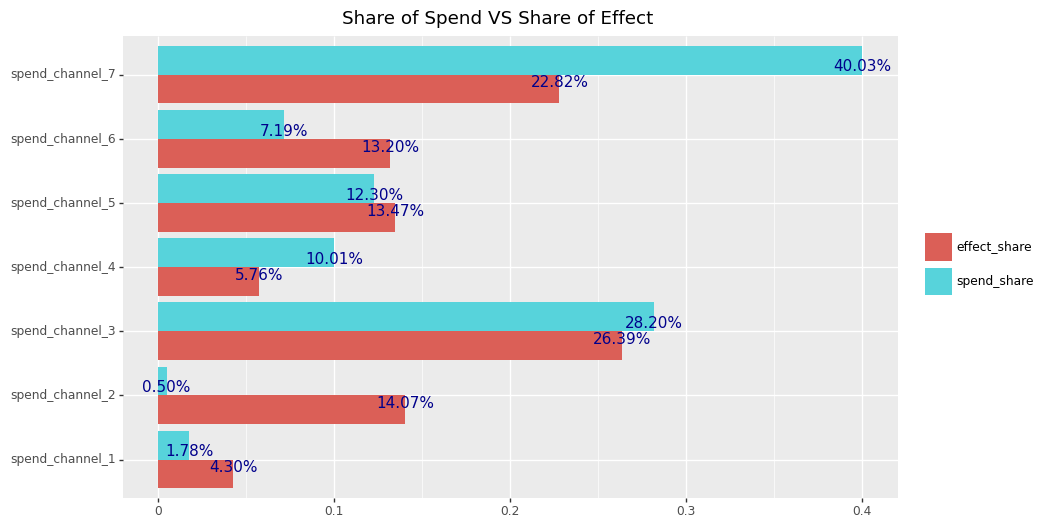

<ggplot: (8745441145992)>

In [ ]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))

Delay Channels: Adding spend_channel_1
Delay Channels: Adding spend_channel_2
Delay Channels: Adding spend_channel_3
Delay Channels: Adding spend_channel_4
Delay Channels: Adding spend_channel_5
Delay Channels: Adding spend_channel_6
Delay Channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season


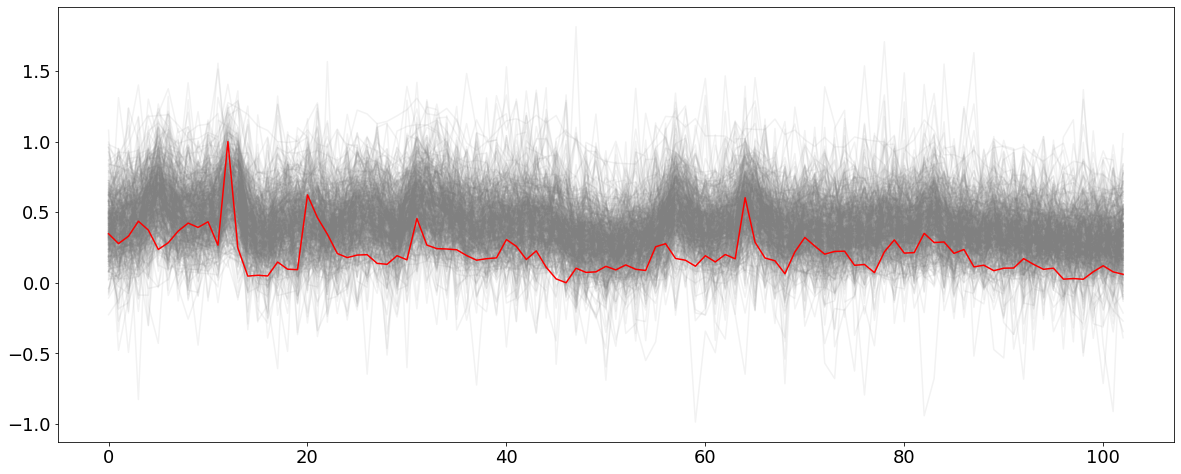

In [ ]:
transform_variables = ["trend",	"season", "spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

delay_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

media_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

control_variables = ["trend", "season"]


data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

#dependent_transformation = PowerTransformer(method = "box-cox")
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

#############


    
response_mean = []
with pm.Model() as model_3:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 0.1)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", 0.1, sd = 0.1)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    #intercept = pm.Normal("intercept", mu = 0.10, sd = 0.1)
    intercept = pm.HalfNormal("intercept", 0.1)
        
    sigma = pm.HalfNormal("sigma", 0.15)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        
######################

with model_3:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

adstock priors: 7
alpha priors: 7
gamma priors: 7
media coef priors: 7
control coef priors: 3
sigma prior: 1


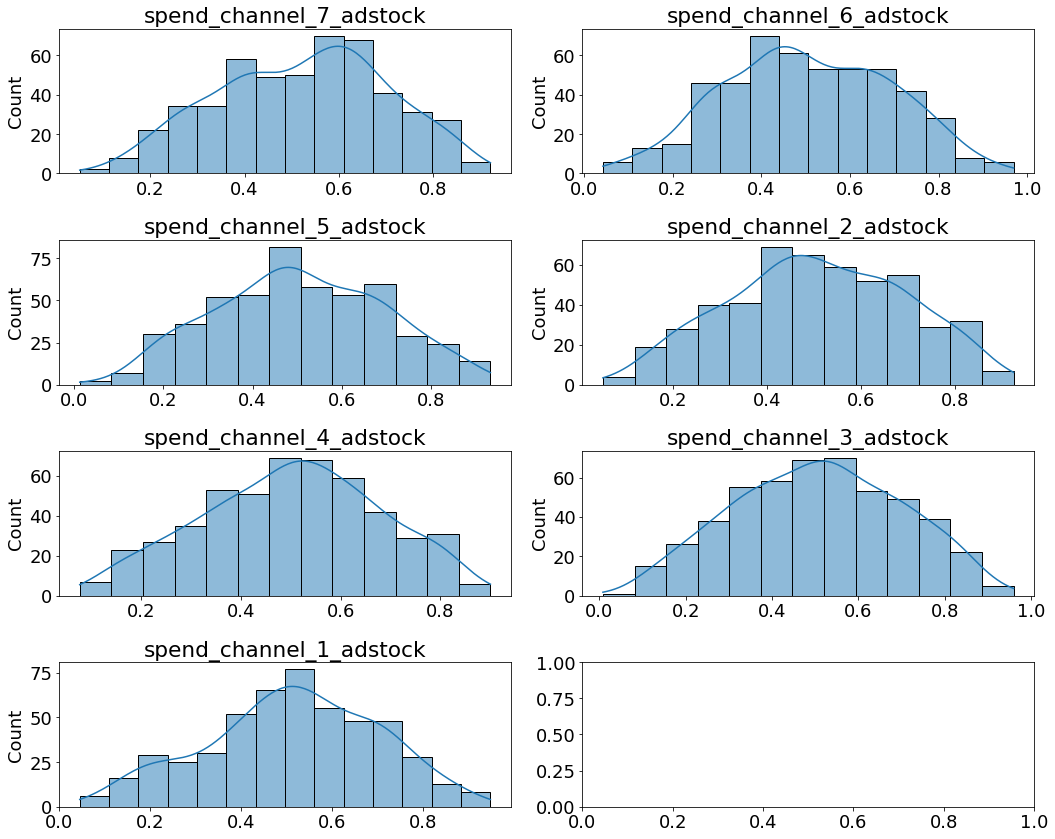

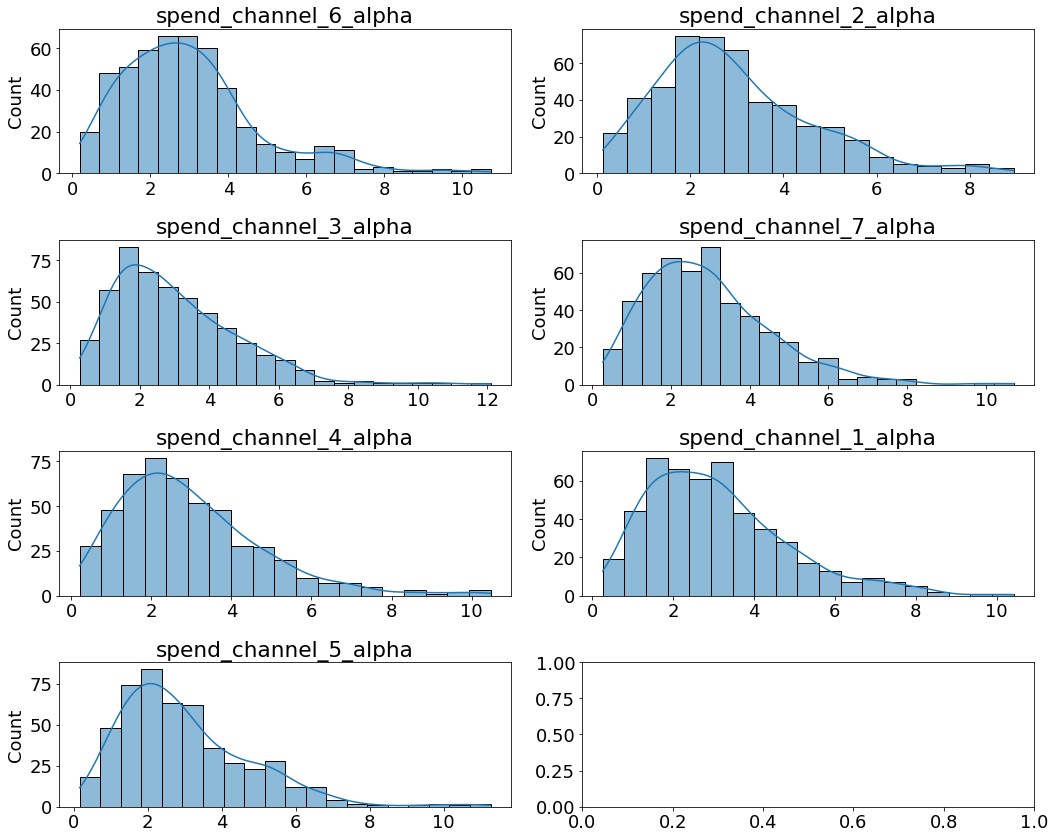

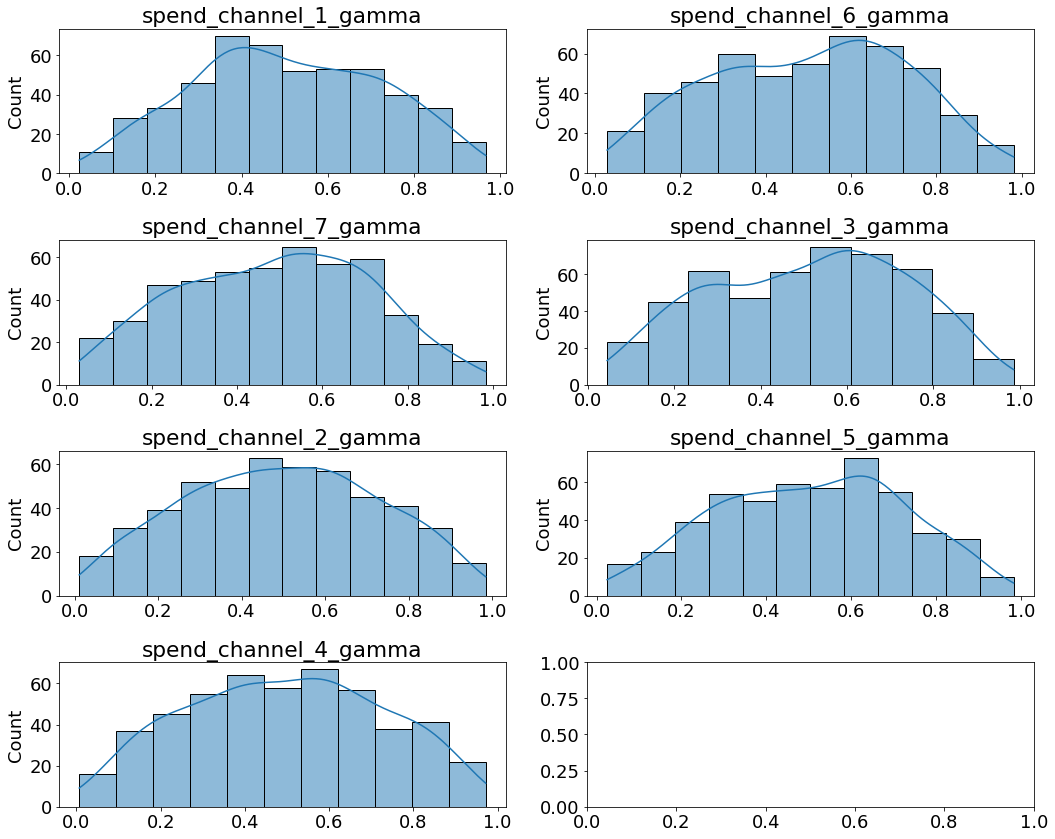

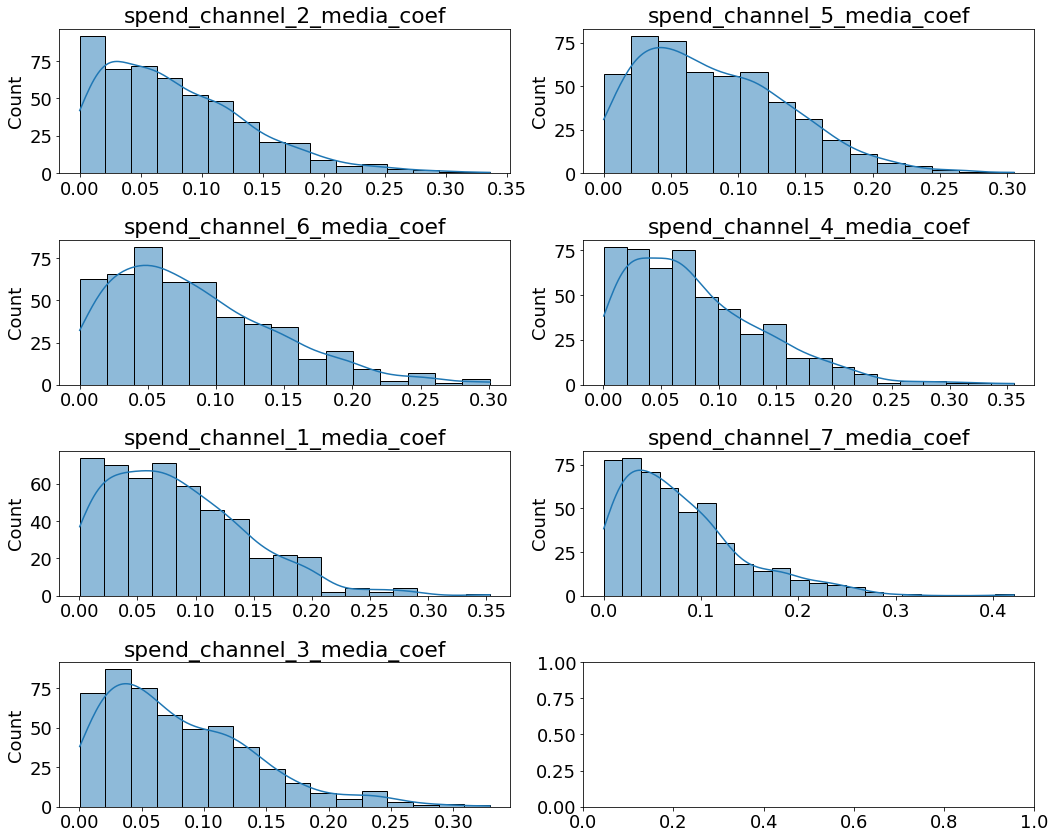

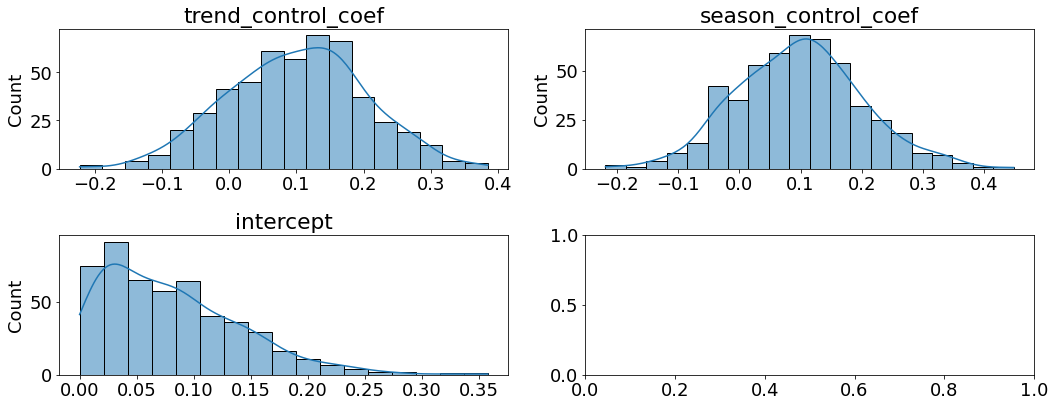

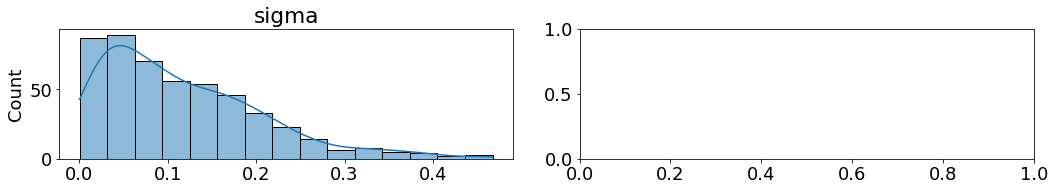

In [ ]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]

adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

In [ ]:
with model_3:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

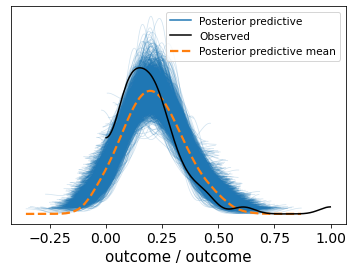

In [ ]:
with model_3:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_3), var_names = ["outcome"])

In [ ]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    mean_variable = ppc_all[variable].mean()
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))
print(nrmse(y_true, y_pred))


adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))

34899.74259310336
0.18888602300566107
0.09831486956070974


In [ ]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = dependent_transformation.inverse_transform(data_transformed_decomposed["prediction"].values.reshape(-1,1))[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].reshape(-1)

Intercept: 0.01285168868039784
spend_channel_1
	adstock 0.47989128623438065 transformation
	saturation alpha 2.862231421261458, gamma 0.5350552820103919 transformation
	coefficient: 0.027783637760977635
spend_channel_2
	adstock 0.3936195193133901 transformation
	saturation alpha 3.2214668391556396, gamma 0.5859744053969127 transformation
	coefficient: 0.04215586903719999
spend_channel_3
	adstock 0.30365685950178484 transformation
	saturation alpha 4.011429828162849, gamma 0.6664190730679238 transformation
	coefficient: 0.09181241341092311
spend_channel_4
	adstock 0.3960481068077457 transformation
	saturation alpha 3.25013339662156, gamma 0.5772408766061902 transformation
	coefficient: 0.04211691816719812
spend_channel_5
	adstock 0.343596560590392 transformation
	saturation alpha 4.035342397069367, gamma 0.6124447798542698 transformation
	coefficient: 0.08063572242747695
spend_channel_6
	adstock 0.38603619189143545 transformation
	saturation alpha 3.908401393598949, gamma 0.447870811965

In [ ]:
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)


print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred)}")

RMSE: 34899.74259310336
MAPE: 0.18888602300566107
NRMSE: 0.09831486956070974


RMSE: 34479.23037024016
MAPE: 0.17806709304140417
NRMSE: 0.09713025898001024


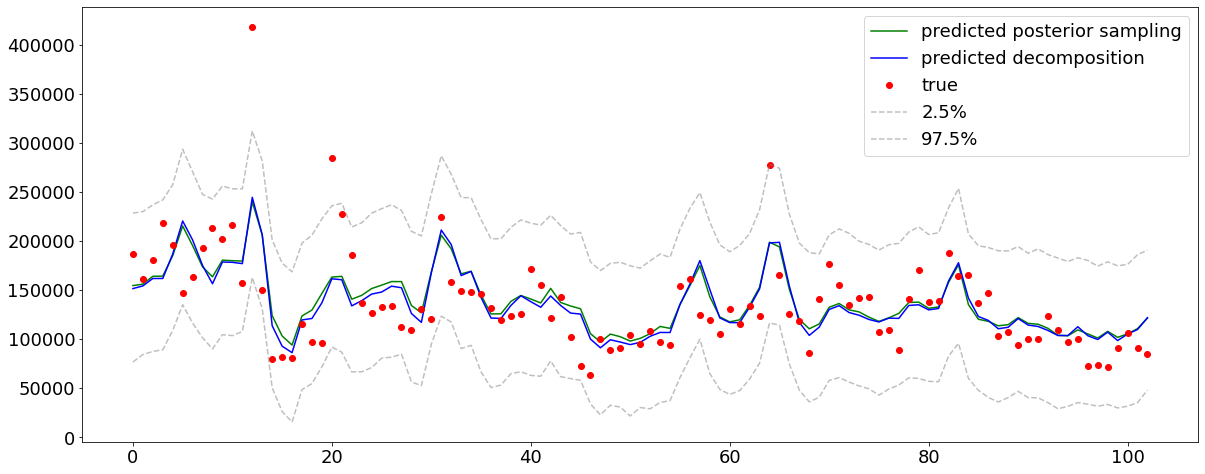

In [ ]:
print(f"RMSE: {np.sqrt(np.mean((y_true - y_pred_decomposed)**2))}")
print(f"MAPE: {np.mean(np.abs((y_true - y_pred_decomposed) / y_true))}")
print(f"NRMSE: {nrmse(y_true, y_pred_decomposed)}")

qs = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [ ]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,spend_channel_1,126917.41986,0.01776
1,spend_channel_2,35475.94995,0.00496
2,spend_channel_3,2015792.38852,0.28200
3,spend_channel_4,715564.58927,0.10010
4,spend_channel_5,878908.29883,0.12296
5,spend_channel_6,513965.57943,0.07190
6,spend_channel_7,2861562.41783,0.40032


In [ ]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,spend_channel_1,0.54484,0.05026
1,spend_channel_2,0.95643,0.08822
2,spend_channel_3,2.10300,0.19398
3,spend_channel_4,0.61847,0.05705
4,spend_channel_5,2.02095,0.18641
5,spend_channel_6,2.91683,0.26904
6,spend_channel_7,1.68098,0.15505


In [ ]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,spend_channel_1,126917.41986,0.01776,0.54484,0.05026
1,spend_channel_2,35475.94995,0.00496,0.95643,0.08822
2,spend_channel_3,2015792.38852,0.28200,2.10300,0.19398
3,spend_channel_4,715564.58927,0.10010,0.61847,0.05705
4,spend_channel_5,878908.29883,0.12296,2.02095,0.18641
5,spend_channel_6,513965.57943,0.07190,2.91683,0.26904
6,spend_channel_7,2861562.41783,0.40032,1.68098,0.15505


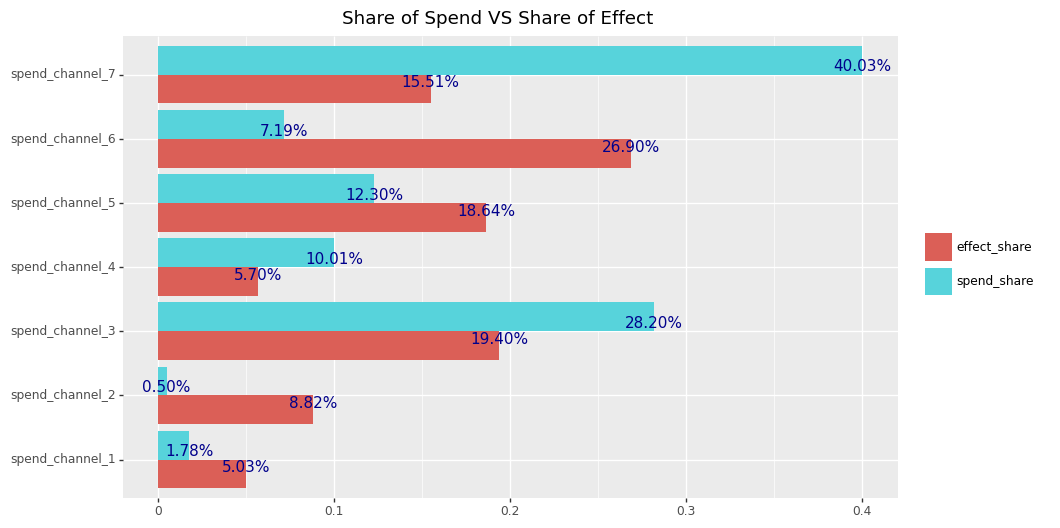

<ggplot: (8745444791531)>

In [ ]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))

Delay Channels: Adding spend_channel_1
Delay Channels: Adding spend_channel_2
Delay Channels: Adding spend_channel_3
Delay Channels: Adding spend_channel_4
Delay Channels: Adding spend_channel_5
Delay Channels: Adding spend_channel_6
Delay Channels: Adding spend_channel_7
Control Variables: Adding trend
Control Variables: Adding season


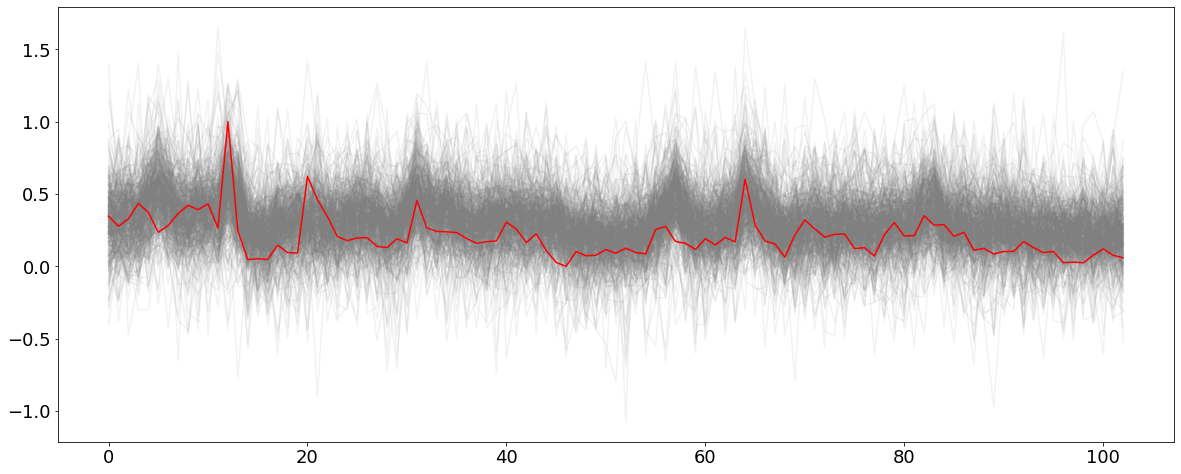

In [ ]:
transform_variables = ["trend",	"season", "spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

delay_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

media_channels = ["spend_channel_1", "spend_channel_2", "spend_channel_3", "spend_channel_4", "spend_channel_5", "spend_channel_6", "spend_channel_7"]

control_variables = ["trend", "season"]

data_transformed = data.copy()

numerical_encoder_dict = {}

for feature in transform_variables:
    scaler = MinMaxScaler()
    original = data[feature].values.reshape(-1, 1)
    transformed = scaler.fit_transform(original)
    data_transformed[feature] = transformed
    numerical_encoder_dict[feature] = scaler

#dependent_transformation = PowerTransformer(method = "box-cox")
dependent_transformation = MinMaxScaler()
original = data[target].values.reshape(-1, 1)
transformed = dependent_transformation.fit_transform(original)
data_transformed[target] = transformed

#############


    
response_mean = []
with pm.Model() as model_4:
    for channel_name in delay_channels:
        print(f"Delay Channels: Adding {channel_name}")
        
        x = data_transformed[channel_name].values
        
        
        
        #adstock_param = pm.Beta(f"{channel_name}_adstock", 3, 3)
        if channel_name == "spend_channel_1":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.2)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_2":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.2)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_3":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.4)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_4":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.3)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_5":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.4)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_6":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.5)(f"{channel_name}_adstock", 3, 3)
        elif channel_name == "spend_channel_7":
            adstock_param = pm.Bound(pm.Beta, lower=0.0, upper=0.8)(f"{channel_name}_adstock", 3, 3)
        else:
            raise Exception(f"unknown channel: {channel_name}")
        
        #saturation_gamma = pm.Beta(f"{channel_name}_gamma", 2, 2)
        if channel_name == "spend_channel_1":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_2":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_3":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_4":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_5":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_6":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        elif channel_name == "spend_channel_7":
            saturation_gamma = pm.Bound(pm.Beta, lower=0.3, upper=1.0)(f"{channel_name}_gamma", 2, 2)
        else:
            raise Exception(f"unknown channel: {channel_name}")
        
        
        saturation_alpha = pm.Gamma(f"{channel_name}_alpha", 3, 1)
        
        x_new = adstock_geometric_theano_pymc3(x, adstock_param)
        x_new_sliced = x_new[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        saturation_tensor = saturation_hill_pymc3(x_new_sliced, saturation_alpha, saturation_gamma)
        
        channel_b = pm.HalfNormal(f"{channel_name}_media_coef", sd = 0.1)
        response_mean.append(saturation_tensor * channel_b)
        
    for control_var in control_variables:
        print(f"Control Variables: Adding {control_var}")
        
        x = data_transformed[control_var].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
        
        control_beta = pm.Normal(f"{control_var}_control_coef", 0.1, sd = 0.1)
        control_x = control_beta * x
        response_mean.append(control_x)
        
    #intercept = pm.Normal("intercept", mu = 0.10, sd = 0.1)
    intercept = pm.HalfNormal("intercept", 0.1)
        
    sigma = pm.HalfNormal("sigma", 0.15)
    
    likelihood = pm.Normal("outcome", mu = intercept + sum(response_mean), sd = sigma, observed = data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX])
        
######################

with model_4:
    prior_pred = pm.sample_prior_predictive()
    
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(prior_pred["outcome"].T, color = "0.5", alpha = 0.1)
_ = ax.plot(data_transformed[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], color = "red")

adstock priors: 7
alpha priors: 7
gamma priors: 7
media coef priors: 7
control coef priors: 3
sigma prior: 1


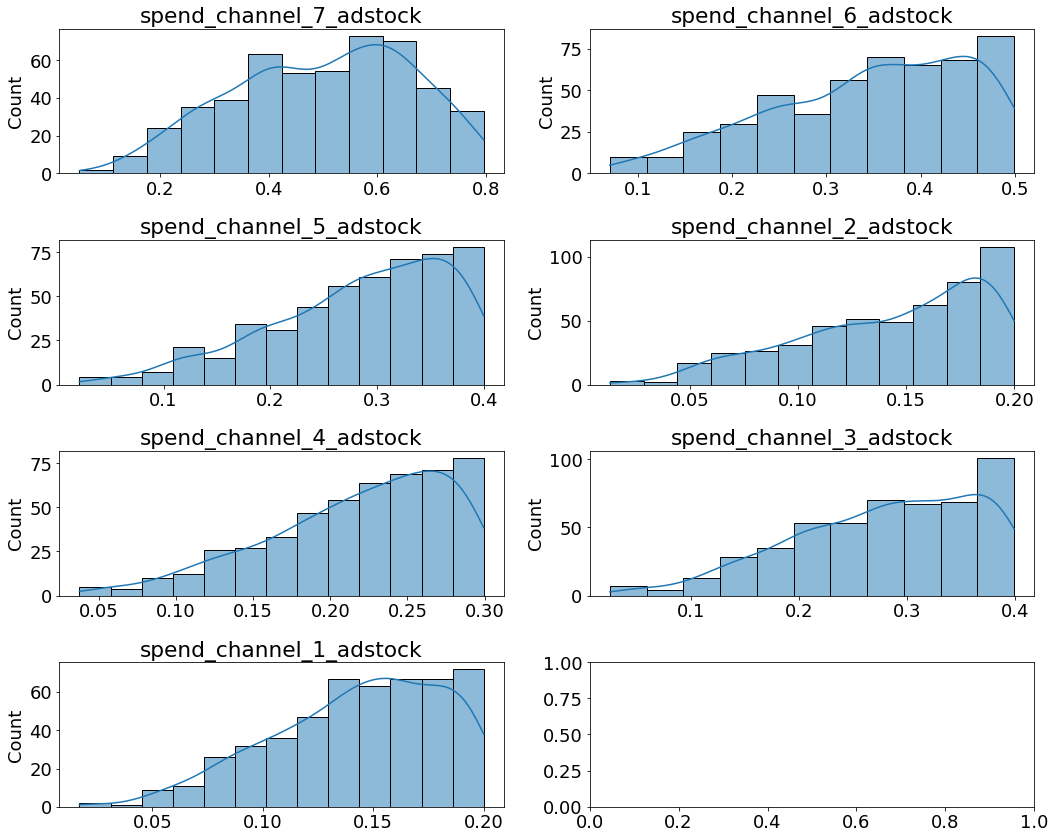

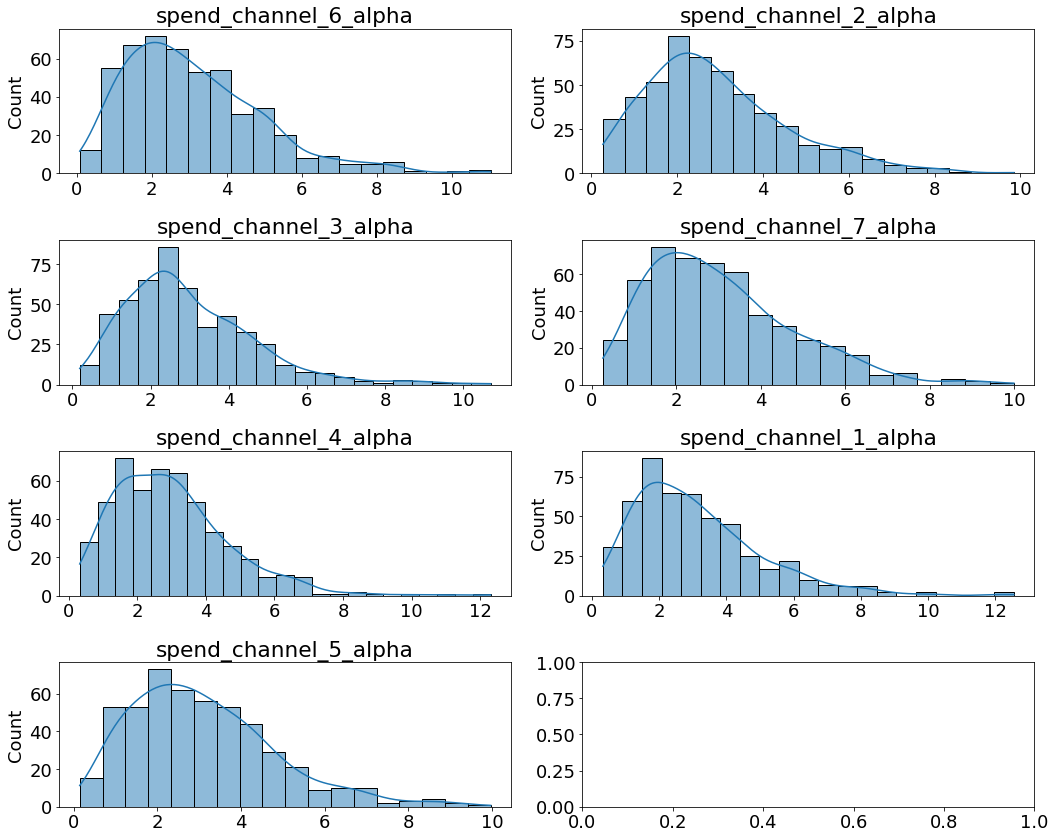

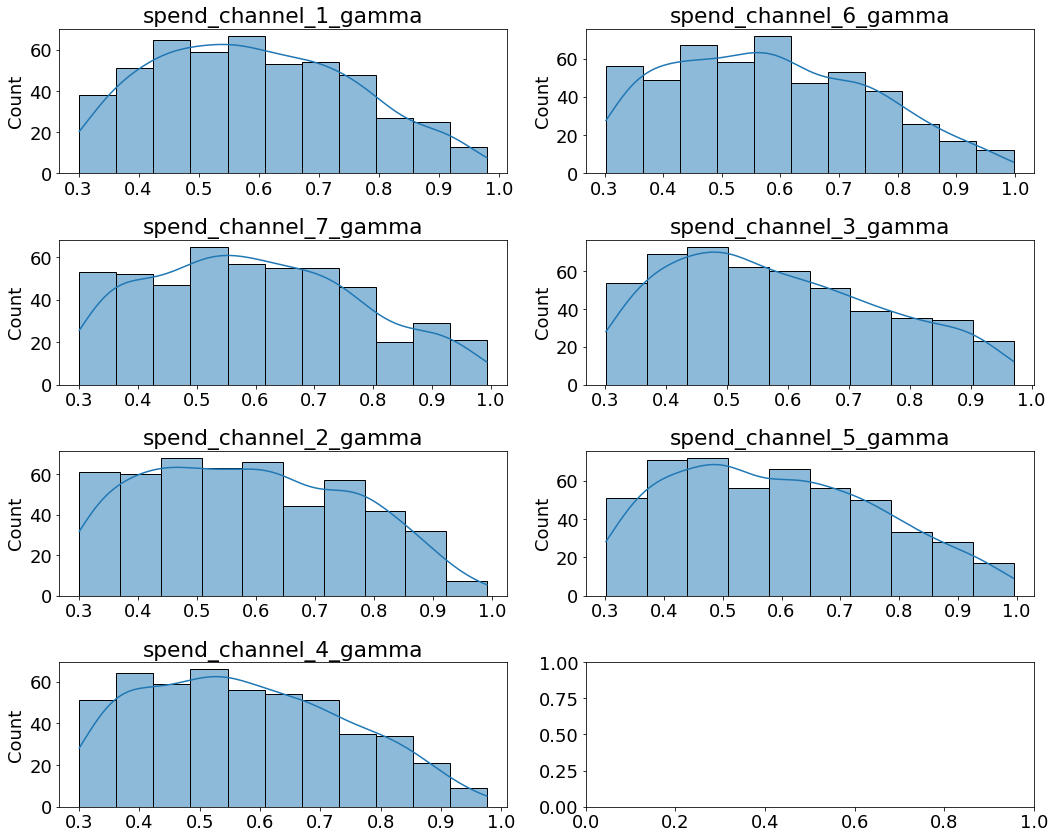

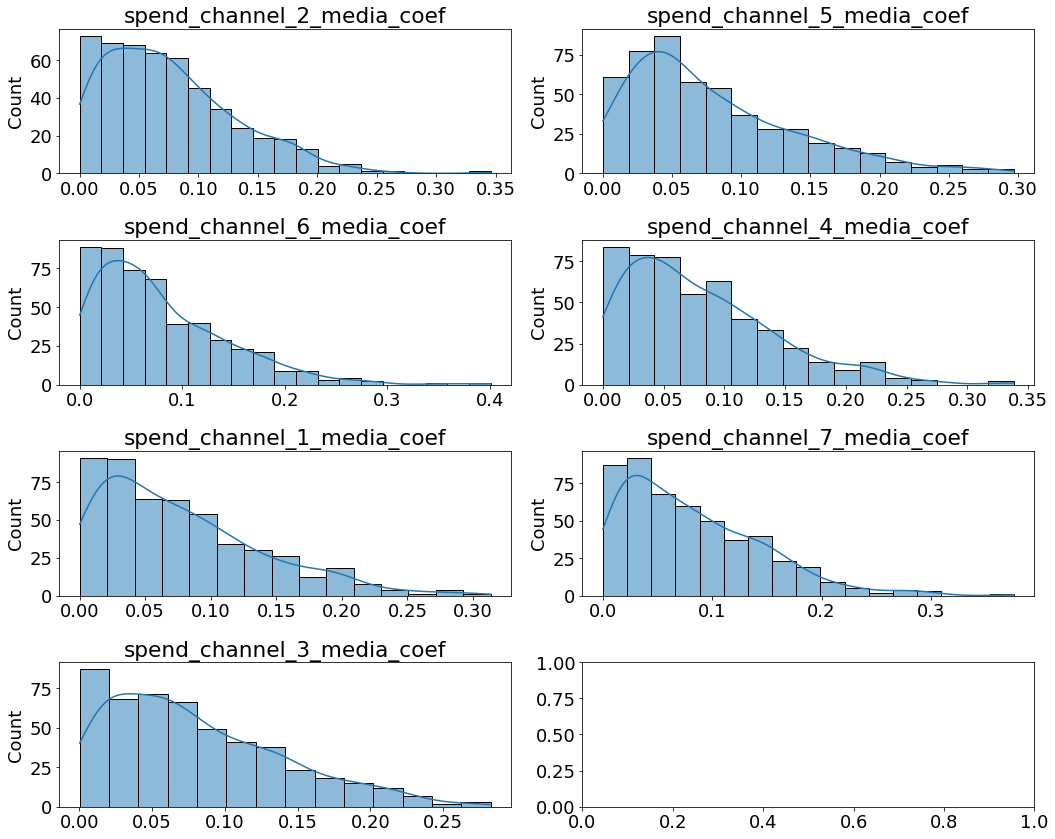

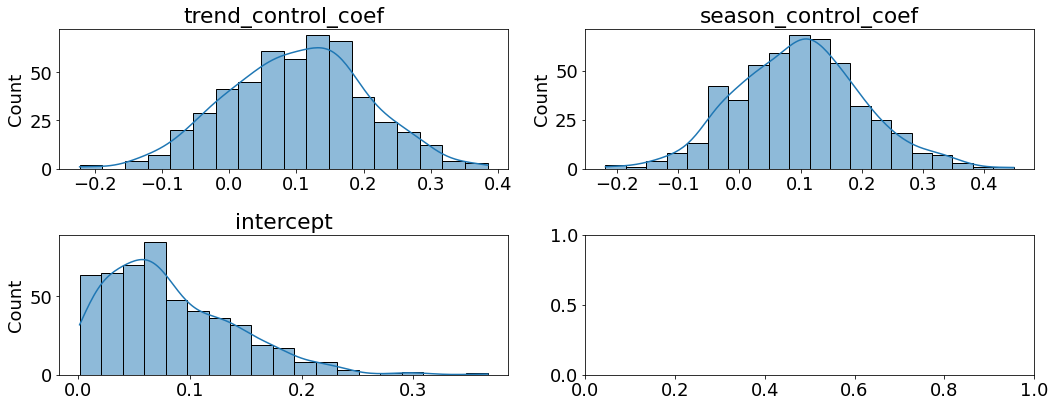

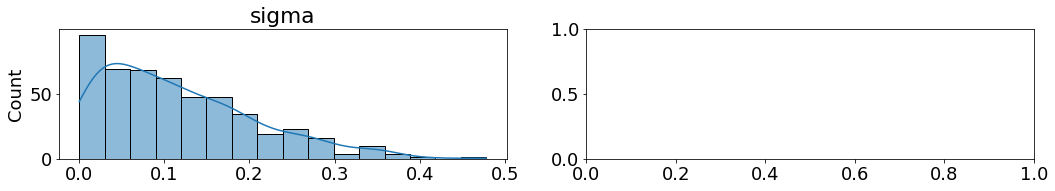

In [ ]:
prior_names = [prior_name for prior_name in list(prior_pred.keys()) if (prior_name.endswith("logodds__") == False) & (prior_name.endswith("_log__") == False)]

adstock_priors = [p for p in prior_names if p.endswith("adstock")]
plot_priors(adstock_priors, prior_pred)
print(f"adstock priors: {len(adstock_priors)}")

alpha_priors = [p for p in prior_names if p.endswith("alpha")]
plot_priors(alpha_priors, prior_pred)
print(f"alpha priors: {len(alpha_priors)}")

gamma_priors = [p for p in prior_names if p.endswith("gamma")]
plot_priors(gamma_priors, prior_pred)
print(f"gamma priors: {len(gamma_priors)}")


media_coef_priors = [p for p in prior_names if p.endswith("media_coef")]
plot_priors(media_coef_priors, prior_pred)
print(f"media coef priors: {len(media_coef_priors)}")

control_coef_priors = [p for p in prior_names if p.endswith("control_coef")] + ["intercept"]
plot_priors(control_coef_priors, prior_pred)
print(f"control coef priors: {len(control_coef_priors)}")

plot_priors(["sigma"], prior_pred)
print(f"sigma prior: 1")

In [ ]:
with model_4:
    trace = pm.sample(1000, tune=1000, step=None, target_accept = 0.95, return_inferencedata=True)
    trace_summary = az.summary(trace)

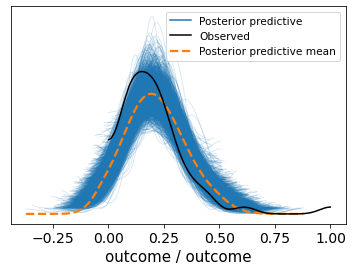

In [ ]:
with model_4:
    ppc_all = pm.sample_posterior_predictive(
        trace, var_names=["outcome"] + list(trace_summary.index), random_seed=42
    )
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc_all, model=model_3), var_names = ["outcome"])

In [ ]:
trace_summary = az.summary(trace)
trace_summary = trace_summary.rename(columns={'mean': 'old_mean'})
trace_summary["mean"] = np.inf


for variable in list(trace_summary.index):
    mean_variable = ppc_all[variable].mean()
    trace_summary.loc[trace_summary.index == variable, "mean"] = mean_variable
	
	
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)

print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))
print(nrmse(y_true, y_pred))


adstock_params = trace_summary[trace_summary.index.str.contains("adstock")][["mean", "sd"]].reset_index().rename(columns = {'index': 'name'}).assign(name = lambda x: x["name"].str.replace("_adstock", ""))
saturation_params = pd.merge(
    trace_summary[trace_summary.index.str.contains("gamma")][["mean"]].reset_index().rename(columns = {'mean': 'gamma'}).assign(name = lambda x: x["index"].str.replace("_gamma", "")), 
    trace_summary[trace_summary.index.str.contains("alpha")][["mean"]].reset_index().rename(columns = {'mean': 'alpha'}).assign(name = lambda x: x["index"].str.replace("_alpha", "")), on = "name" )
control_coefficients = trace_summary[trace_summary.index.str.contains("_control_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_control_coef", ""))
delay_coefficients = trace_summary[trace_summary.index.str.contains("_media_coef")][["mean", "sd"]].reset_index().assign(name = lambda x: x["index"].str.replace("_media_coef", ""))

34340.6452480877
0.1845012568680251
0.09673985557886404


In [ ]:
data_transformed_decomposed = data_transformed.copy()
intercept = trace_summary[trace_summary.index == "intercept"]["mean"].iloc[0]
data_transformed_decomposed["intercept"] = intercept
print(f"Intercept: {intercept}")

for delay_channel in delay_channels:
    print(delay_channel)
    
    adstock = adstock_params[adstock_params.name == delay_channel]
    adstock_theta = adstock["mean"].iloc[0]
    
    print(f"\tadstock {adstock_theta} transformation")
    
    data_transformed_decomposed[delay_channel] = adstock_geometric(data_transformed_decomposed[delay_channel].values, theta = adstock_theta)
    
    saturation = saturation_params[saturation_params.name == delay_channel]
    
    saturation_alpha = saturation["alpha"].iloc[0]
    saturation_gamma = saturation["gamma"].iloc[0]
    
    print(f"\tsaturation alpha {saturation_alpha}, gamma {saturation_gamma} transformation")
    
    #use the unbound version of saturation
    data_transformed_decomposed[delay_channel] = saturation_hill_pymc3(data_transformed_decomposed[delay_channel].values, alpha = saturation_alpha, gamma = saturation_gamma)
    
    coefs = delay_coefficients[delay_coefficients.name == delay_channel]
    coef = coefs["mean"].iloc[0]
    
    data_transformed_decomposed[delay_channel] = data_transformed_decomposed[delay_channel] * coef
    print(f"\tcoefficient: {coef}")
    
#apply coefficients

for variable in control_variables:
    coefs = control_coefficients[control_coefficients.name == variable]
    coef = coefs["mean"].iloc[0]
    print(f"Control Coefficient: {variable}: {coef}")
    data_transformed_decomposed[variable] = data_transformed_decomposed[variable] * coef
    
data_transformed_decomposed["prediction"] = data_transformed_decomposed[delay_channels + control_variables + ["intercept"]].sum(axis = 1)
y_pred_decomposed = dependent_transformation.inverse_transform(data_transformed_decomposed["prediction"].values.reshape(-1,1))[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].reshape(-1)

Intercept: 0.013940723707813935
spend_channel_1
	adstock 0.14428583800617326 transformation
	saturation alpha 2.9194546401958608, gamma 0.5945639352894286 transformation
	coefficient: 0.03307809716289121
spend_channel_2
	adstock 0.1428860549594832 transformation
	saturation alpha 3.370997710212692, gamma 0.6013795514454972 transformation
	coefficient: 0.06096504963053978
spend_channel_3
	adstock 0.24813521868044378 transformation
	saturation alpha 3.8532572978812114, gamma 0.6553652243181329 transformation
	coefficient: 0.09652262851087119
spend_channel_4
	adstock 0.20689762171243545 transformation
	saturation alpha 3.1840892261374654, gamma 0.600819649913903 transformation
	coefficient: 0.053120261312907376
spend_channel_5
	adstock 0.26964892808194646 transformation
	saturation alpha 4.097308404462958, gamma 0.6009640147783338 transformation
	coefficient: 0.08656034604998147
spend_channel_6
	adstock 0.3578112383879693 transformation
	saturation alpha 4.0315041988926525, gamma 0.448296

In [ ]:
y_true = data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX]
y_pred = dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)).reshape(-1)


print(np.sqrt(np.mean((y_true - y_pred)**2)))
print(np.mean(np.abs((y_true - y_pred) / y_true)))

34340.6452480877
0.1845012568680251


34089.90090525709
0.17267070859928865


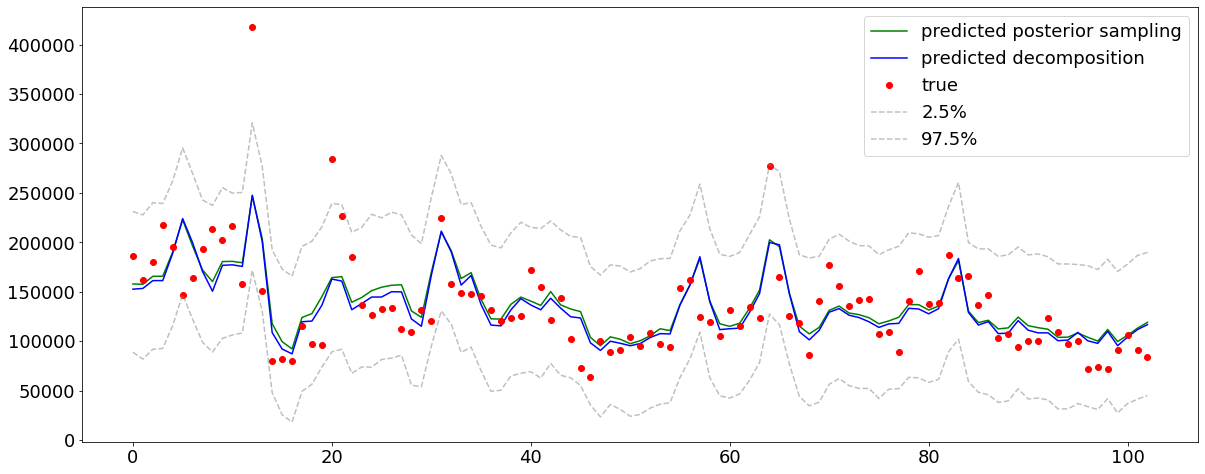

In [ ]:
print(np.sqrt(np.mean((y_true - y_pred_decomposed)**2)))
print(np.mean(np.abs((y_true - y_pred_decomposed) / y_true)))

qs = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
qs_decomposed = mquantiles(dependent_transformation.inverse_transform(ppc_all["outcome"]), [0.025, 0.975], axis=0)
fig, ax = plt.subplots(figsize = (20, 8))
_ = ax.plot(dependent_transformation.inverse_transform(ppc_all["outcome"].mean(axis = 0).reshape(-1, 1)), color = "green", label = "predicted posterior sampling")
_ = ax.plot(y_pred_decomposed, color = "blue", label = "predicted decomposition")
_ = ax.plot(data[target].values[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX], 'ro', label = "true")
_ = ax.plot(qs[0], '--', color = "grey", label = "2.5%", alpha = 0.5)
_ = ax.plot(qs[1], '--', color = "grey", label = "97.5%", alpha = 0.5)
_ = ax.legend()

In [ ]:
spend_df = pd.DataFrame()
for media_channel in media_channels:
    temp_series = data[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    #exposure to spend should
    if len(media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]) > 0:
        
        vmax = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["V_max"].iloc[0]
        km = media_spend_exposure_df[media_spend_exposure_df.exposure == media_channel]["K_m"].iloc[0]
        spends = exposure_to_spend_menten_func(temp_series, V_max = vmax, K_m = km)
        spends_total = spends.sum()
    else:
        spends_total = temp_series.sum()
        
    spend_df = pd.concat([spend_df, pd.DataFrame({'media': [media_channel], 'total_spend': [spends_total]})]).reset_index(drop=True)

spend_df["spend_share"] = spend_df["total_spend"] / spend_df["total_spend"].sum()
spend_df

,media,total_spend,spend_share
0,spend_channel_1,126917.41986,0.01776
1,spend_channel_2,35475.94995,0.00496
2,spend_channel_3,2015792.38852,0.28200
3,spend_channel_4,715564.58927,0.10010
4,spend_channel_5,878908.29883,0.12296
5,spend_channel_6,513965.57943,0.07190
6,spend_channel_7,2861562.41783,0.40032


In [ ]:
response_df = pd.DataFrame()
for media_channel in media_channels:
    response = data_transformed_decomposed[media_channel].iloc[START_ANALYSIS_INDEX:END_ANALYSIS_INDEX].values
    response_total = response.sum()
    
    response_df = pd.concat([response_df, pd.DataFrame({'media': [media_channel], 'total_effect': [response_total]})]).reset_index(drop=True)
response_df["effect_share"] = response_df["total_effect"] / response_df["total_effect"].sum()

response_df

,media,total_effect,effect_share
0,spend_channel_1,0.24252,0.02469
1,spend_channel_2,0.79361,0.08079
2,spend_channel_3,1.99605,0.20321
3,spend_channel_4,0.46277,0.04711
4,spend_channel_5,1.88383,0.19178
5,spend_channel_6,2.83473,0.28859
6,spend_channel_7,1.60919,0.16382


In [ ]:
spend_response_share_df = pd.concat([spend_df, response_df.drop(columns=["media"])], axis = 1)
spend_response_share_df

,media,total_spend,spend_share,total_effect,effect_share
0,spend_channel_1,126917.41986,0.01776,0.24252,0.02469
1,spend_channel_2,35475.94995,0.00496,0.79361,0.08079
2,spend_channel_3,2015792.38852,0.28200,1.99605,0.20321
3,spend_channel_4,715564.58927,0.10010,0.46277,0.04711
4,spend_channel_5,878908.29883,0.12296,1.88383,0.19178
5,spend_channel_6,513965.57943,0.07190,2.83473,0.28859
6,spend_channel_7,2861562.41783,0.40032,1.60919,0.16382


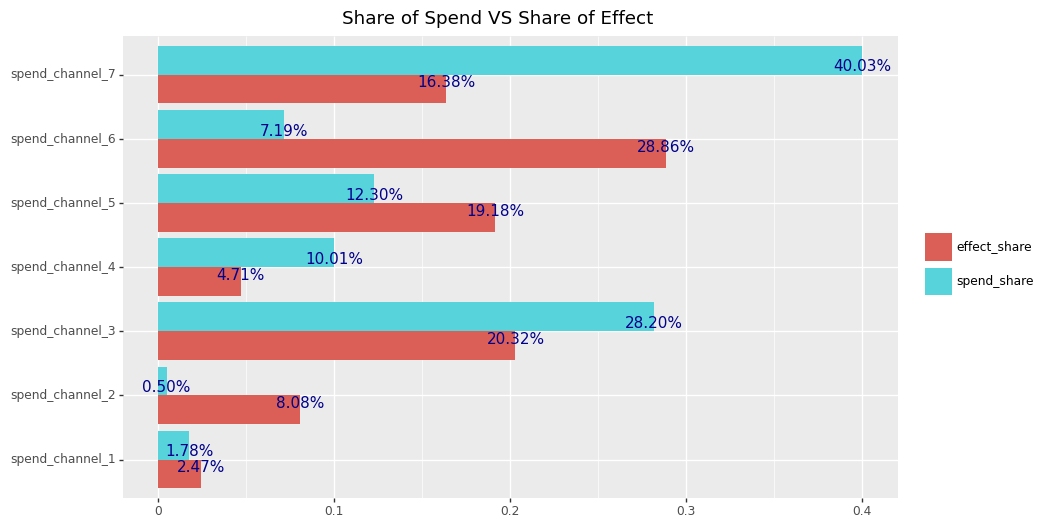

<ggplot: (8745407213050)>

In [ ]:
plot_spend_vs_effect_share(spend_response_share_df, figure_size = (10, 6))